# Analyse av Runkeeper-data

### Flere ideer

https://ocefpaf.github.io/python4oceanographers/blog/2014/08/18/gpx/

https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d

- Vis hvor mye jeg har løpt per år/mnd

- Ha forskjellig farge på hver tur etter hvor langt jeg løp:

https://medium.com/@madhuramiah/geographic-plotting-with-python-folium-2f235cc167b7

https://betterfigures.org/2015/06/23/picking-a-colour-scale-for-scientific-graphics/

### Importerer pakker

In [1]:
import gpxpy
import matplotlib.pyplot as plt
import datetime
from geopy import distance
from math import sqrt, floor
import numpy as np
import pandas as pd
import haversine
import folium
from folium.plugins import HeatMap
import glob
import os

### Laster og behandler alle gpx-datene med en funksjon

https://ocefpaf.github.io/python4oceanographers/blog/2014/08/18/gpx/

In [2]:
def load_run_data(filter=""):
    gpx_files = glob.glob('Data/' + filter + '*.gpx')    
    run_data = []
    for file_idx, gpx_file in enumerate(gpx_files): 
        gpx = gpxpy.parse(open(gpx_file, 'r'))
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            track_speed = track.get_moving_data().max_speed
            
            for seg_idx, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    run_data.append([file_idx, os.path.basename(gpx_file), track_idx, track_name, 
                                     track_time, track_length, track_duration, track_speed, 
                                     seg_idx, segment_length, point.time, point.latitude, 
                                     point.longitude, point.elevation, segment.get_speed(point_idx)])
    return run_data

### Lager DataFrame av gpx-datene

In [3]:
data = load_run_data(filter="")
df = pd.DataFrame(data, columns=['File_Index', 'File_Name', 'Index', 'Name',
                              'Time', 'Length', 'Duration', 'Max_Speed',
                              'Segment_Index', 'Segment_Length', 'Point_Time', 'Point_Latitude',
                              'Point_Longitude', 'Point_Elevation', 'Point_Speed'])

df.tail()

,File_Index,File_Name,Index,Name,Time,Length,Duration,Max_Speed,Segment_Index,Segment_Length,Point_Time,Point_Latitude,Point_Longitude,Point_Elevation,Point_Speed
152743,335,2019-12-02-161113.gpx,0,Cross-Country Skiing 12/2/19 4:11 pm,2019-12-02 15:11:13+00:00,4250.317829,2222,4.784425,0,4250.317829,2019-12-02 15:47:29+00:00,60.200203,12.006000,202.4,1.506337
152744,335,2019-12-02-161113.gpx,0,Cross-Country Skiing 12/2/19 4:11 pm,2019-12-02 15:11:13+00:00,4250.317829,2222,4.784425,0,4250.317829,2019-12-02 15:47:35+00:00,60.200127,12.006074,202.3,1.454602
152745,335,2019-12-02-161113.gpx,0,Cross-Country Skiing 12/2/19 4:11 pm,2019-12-02 15:11:13+00:00,4250.317829,2222,4.784425,0,4250.317829,2019-12-02 15:47:42+00:00,60.200049,12.006139,202.2,1.235034
152746,335,2019-12-02-161113.gpx,0,Cross-Country Skiing 12/2/19 4:11 pm,2019-12-02 15:11:13+00:00,4250.317829,2222,4.784425,0,4250.317829,2019-12-02 15:47:51+00:00,60.199978,12.006254,202.1,0.734641
152747,335,2019-12-02-161113.gpx,0,Cross-Country Skiing 12/2/19 4:11 pm,2019-12-02 15:11:13+00:00,4250.317829,2222,4.784425,0,4250.317829,2019-12-02 15:48:15+00:00,60.199912,12.006320,202.0,0.341874


### Lager kart for alle turene

In [5]:
Start = 0
Stopp = 336

data_kart = df[['File_Index','Point_Latitude','Point_Longitude']]
kart = folium.Map(tiles = "cartodbpositron")
for Tur_nr in range(Start,Stopp):
    
    data_kart = df.loc[df['File_Index'] == Tur_nr]
    data_kart = [[row['Point_Latitude'],row['Point_Longitude']] for i, row in data_kart.iterrows()]
    folium.PolyLine(data_kart, radius=10).add_to(kart)
    
# Må kartet som html for å kunne vise det:
#kart.save('kartet_mitt.html')

# Viser kart
#kart

### Test med farger

https://medium.com/@madhuramiah/geographic-plotting-with-python-folium-2f235cc167b7

Frisk opp hvordan lambda fungerer

Ideer til farger jeg kan velge (obs. ikke velg hvit (synes ikke):

https://betterfigures.org/2015/06/23/picking-a-colour-scale-for-scientific-graphics/

In [84]:
# Test farger - Ulik farge per tur
# Fungerer
colors = {334:'red', 335:'blue', 3:'green'}

df_test = df.loc[df['File_Index'] > 333]

color=df_test['File_Index'].apply(lambda x: colors[x])

color.head()

151362    red
151363    red
151364    red
151365    red
151366    red
Name: File_Index, dtype: object

In [141]:
# Test farger - Ulik farge etter lengde på tur
# Fungerer med eksakt verdi
colors = {10311.580377154603:'red', 4250.317828866015:'blue', 3:'green'}

df_test = df.loc[df['File_Index'] > 333]

color=df_test['Segment_Length'].apply(lambda x: colors[x])
color.head()

151362    red
151363    red
151364    red
151365    red
151366    red
Name: Segment_Length, dtype: object

In [86]:
# Test farger - Ulik farge etter lengde på tur
# Fungerer ikke pga. kommatall (float)
colors = {range(0,5000):'red',
         range(5001,12000):'blue'}

df_test = df.loc[df['File_Index'] > 333]

color=df_test['Segment_Length'].apply(lambda x: colors[x])
color.head()

KeyError: 10311.580377154603

In [132]:
# Test drop duplicate
df2=df.drop_duplicates(subset=['File_Index','Segment_Length'])

df2

,File_Index,File_Name,Index,Name,Time,Length,Duration,Max_Speed,Segment_Index,Segment_Length,Point_Time,Point_Latitude,Point_Longitude,Point_Elevation,Point_Speed
0,0,2013-08-11-175739.gpx,0,Running 8/11/13 5:57 pm,2013-08-11 15:57:39+00:00,2191.795553,831,3.262928,0,2191.795553,2013-08-11 15:57:39+00:00,60.835544,11.675420,213.0,0.000000
209,1,2013-08-14-172941.gpx,0,Running 8/14/13 5:29 pm,2013-08-14 15:29:41+00:00,2227.521604,818,3.392670,0,2227.521604,2013-08-14 15:29:41+00:00,60.835550,11.674856,220.0,1.059858
424,2,2013-08-19-191558.gpx,0,Running 8/19/13 7:15 pm,2013-08-19 17:15:58+00:00,2177.474103,761,3.703511,0,2177.474103,2013-08-19 17:15:58+00:00,60.835615,11.675331,213.0,1.582862
631,3,2013-08-24-191606.gpx,0,Running 8/24/13 7:16 pm,2013-08-24 17:16:06+00:00,4395.433895,1821,3.630659,0,4395.433895,2013-08-24 17:16:06+00:00,60.835722,11.675093,213.0,0.448031
1057,4,2013-08-27-173705.gpx,0,Running 8/27/13 5:37 pm,2013-08-27 15:37:05+00:00,5393.901226,2199,3.350971,0,5393.901226,2013-08-27 15:37:05+00:00,60.835561,11.675469,213.0,3.303923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150806,331,2019-09-12-195413.gpx,0,Running 9/12/19 7:54 pm,2019-09-12 17:54:13+00:00,1321.558815,379,3.984562,0,1321.558815,2019-09-12 17:54:13+00:00,60.191032,11.994834,156.0,1.457466
150929,332,2019-09-15-143840.gpx,0,Running 9/15/19 2:38 pm,2019-09-15 12:38:40+00:00,2799.048412,1149,3.960781,0,2799.048412,2019-09-15 12:38:40+00:00,60.203962,11.991125,218.8,2.130433
151194,333,2019-09-18-194749.gpx,0,Running 9/18/19 7:47 pm,2019-09-18 17:47:49+00:00,1757.133914,524,3.904105,0,1757.133914,2019-09-18 17:47:49+00:00,60.190974,11.994754,156.0,1.513502
151362,334,2019-09-21-161604.gpx,0,Running 9/21/19 4:16 pm,2019-09-21 14:16:04+00:00,10311.580377,3134,4.671572,0,10311.580377,2019-09-21 14:16:04+00:00,59.911622,10.733413,16.0,3.281092


## Mulig alternativ for å lage kart med ulike farger

Fra Helt Python session 2:

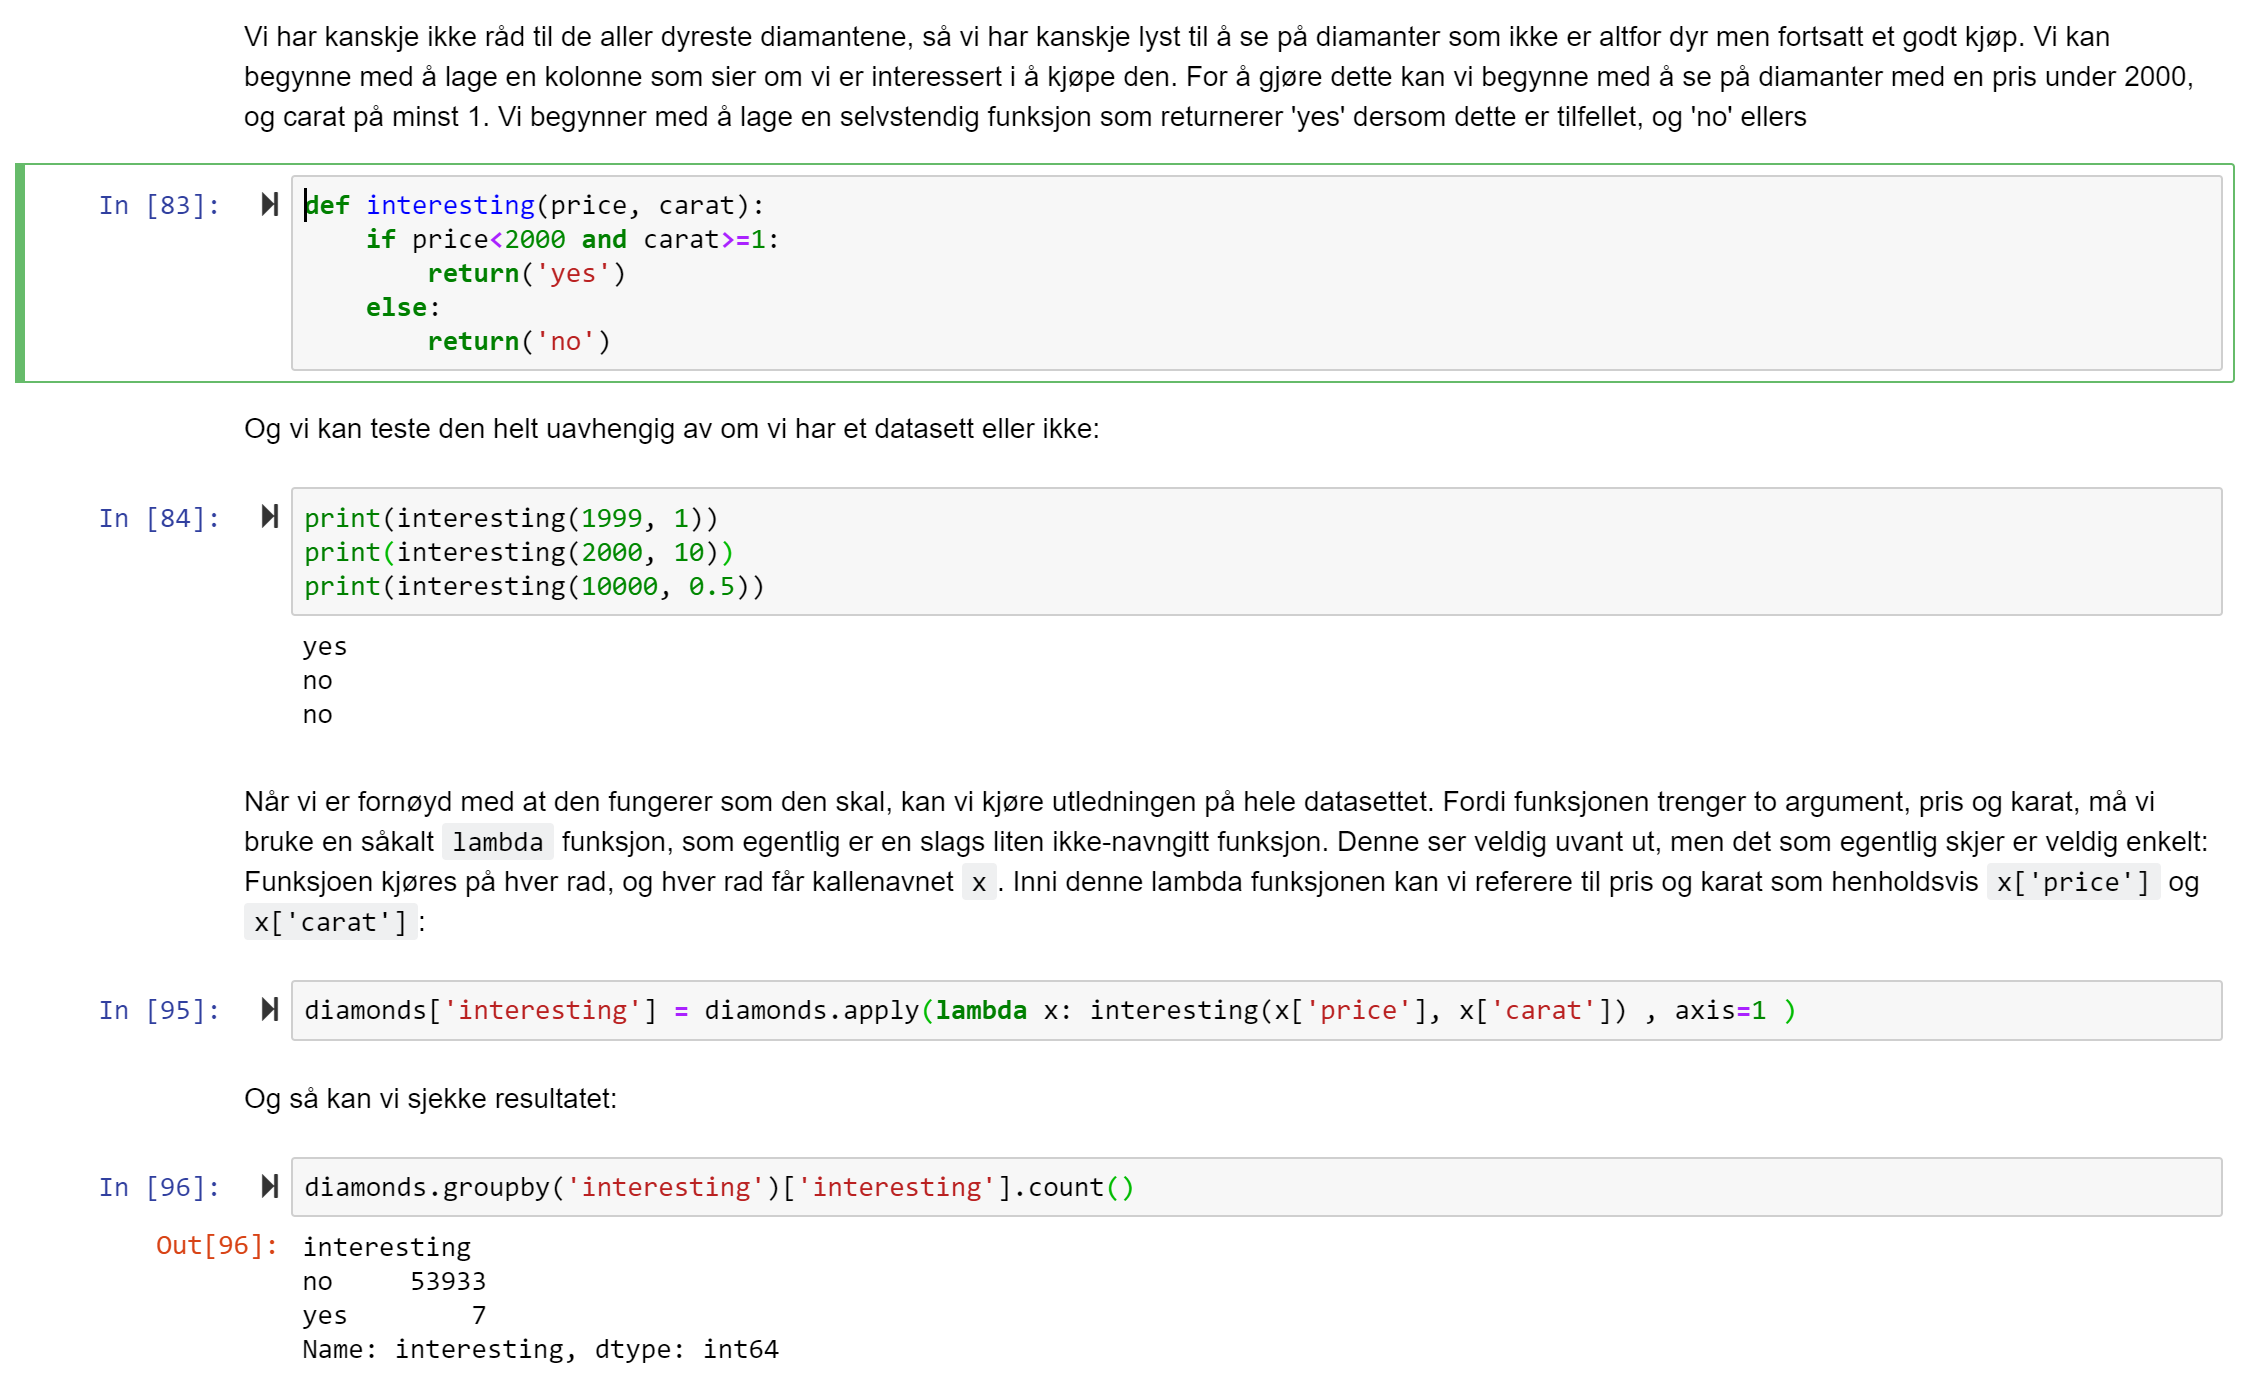

In [160]:
# Test med kart og eksakte verdier
# Fungerer ikke, tror det har noe med at det blir en farge per gpx-punkt
# I denne testen skal det altså bare komme ut to farger når jeg bruker print

# Mulig løsning her:
# https://stackoverflow.com/questions/53637053/folium-color-mapping-when-adding-geojson-to-the-map

# test av ulike farger for lengde på turer
colors = {10311.580377154603:'red', 4250.317828866015:'blue', 3:'green'}

# plt.scatter(x, y, color=df2['Pclass'].apply(lambda x: colors[x]))


Start = 334
Stopp = 336

data_kart = df[['File_Index','Point_Latitude','Point_Longitude','Segment_Length']]
kart = folium.Map(tiles = "cartodbpositron")

for Tur_nr in range(Start,Stopp):
    
    data_kart = df.loc[df['File_Index'] == Tur_nr]
    
# Test med kun en verdi per tur (ser ikke ut tilå gjøre noen forskjell)
#     enkelt_tur = data_kart.drop_duplicates(subset=['File_Index','Segment_Length'])
#     farge = enkelt_tur['Segment_Length'].apply(lambda x: colors[x])

# Bruk denne for å få ut kart
#    farge = 'red'

# Test med verdier for hvert gpx-punkt:
    farge = data_kart['Segment_Length'].apply(lambda x: colors[x])
#    farge = str(farge)

# Printer ut farge for å se om loopen fungerer
    print(farge)
#    print(data_kart)

# Bruk dette for å få ut kart:
#    data_kart = [[row['Point_Latitude'],row['Point_Longitude']] for i, row in data_kart.iterrows()]
#    folium.PolyLine(data_kart, color=farge, radius=10).add_to(kart)

kart

151362    red
151363    red
151364    red
151365    red
151366    red
         ... 
152324    red
152325    red
152326    red
152327    red
152328    red
Name: Segment_Length, Length: 967, dtype: object
152329    blue
152330    blue
152331    blue
152332    blue
152333    blue
          ... 
152743    blue
152744    blue
152745    blue
152746    blue
152747    blue
Name: Segment_Length, Length: 419, dtype: object


In [88]:
# test av ulike farger for lengde på turer
colors = {'1':'red', '2':'blue', '3':'green'}

# plt.scatter(x, y, color=df2['Pclass'].apply(lambda x: colors[x]))


Start = 334
Stopp = 336

data_kart = df[['File_Index','Point_Latitude','Point_Longitude']]
kart = folium.Map(tiles = "cartodbpositron")

for Tur_nr in range(Start,Stopp):
    
    data_kart = df.loc[df['File_Index'] == Tur_nr]
    if Tur_nr == 334:
        farge = '#08306b'
    elif Tur_nr == 335:
        farge = '#4292c6'
    data_kart = [[row['Point_Latitude'],row['Point_Longitude']] for i, row in data_kart.iterrows()]
    folium.PolyLine(data_kart, color=farge, radius=10).add_to(kart)

kart

In [6]:

# farge = df.loc[df['Segment_Length'] > 10000] 

# farge

Start = 334
Stopp = 336

data_kart = df[['File_Index','Point_Latitude','Point_Longitude']]
kart = folium.Map(tiles = "cartodbpositron")

for Tur_nr in range(Start,Stopp):
    
    data_kart = df.loc[df['File_Index'] == Tur_nr]
#     farge = df.loc[df['Segment_Length'] > 10000] #else farge = 'red'

#     blå = data_kart.loc[data_kart['Segment_Length'] > 9000]
#     rød = data_kart.loc[data_kart['Segment_Length'] > 8000]

#     if data_kart.loc[data_kart['Segment_Length'] == 4250.317829]:
#         farge = 'pink'
#     elif data_kart.loc[data_kart['Segment_Length'] != 4250.317829]:
#         farge = 'blue'

#     if Tur_nr == 334:
#         farge = 'blue'
#     elif Tur_nr == 335:
#         farge = 'red'
        
    if Tur_nr == 334:
        farge = '#08306b'
    elif Tur_nr == 335:
        farge = '#4292c6'
        
#     if any(data_kart.loc[data_kart['Segment_Length'] > 10000]):
#         farge = 'black'
#     elif any(data_kart.loc[data_kart['Segment_Length'] < 5000]):
#         farge = 'red'
    
# farge
# #     data_kart.apply(lambda color:'red' if )
# #Segment_Length
# #     .apply(lambda count:"Black" if count>=400 else
# #                                          "green" if count>=300 and count<400 else
# #                                          "Orange" if count>=200 and count<300 else
# #                                          "darkblue" if count>=150 and count<200 else
# #                                          "red" if count>=100 and count<150 else
# #                                          "lightblue" if count>=75 and count<100 else
# #                                          "brown" if count>=50 and count<75 else
# #                                          "grey")
    data_kart = [[row['Point_Latitude'],row['Point_Longitude']] for i, row in data_kart.iterrows()]
    folium.PolyLine(data_kart, color=farge, radius=10).add_to(kart)
    
# # Må kartet som html for å kunne vise det:
# # kart.save('kartet_mitt.html')

# # Viser kart
kart

### Lager heatmap for alle turene

In [6]:
Start = 0
Stopp = 336

data_heatmap = df[['File_Index','Point_Latitude','Point_Longitude']]
kart_heat = folium.Map(tiles = "cartodbpositron")
for Tur_nr in range(Start,Stopp):
    
    data_heatmap = df.loc[df['File_Index'] == Tur_nr]
    data_heatmap = [[row['Point_Latitude'],row['Point_Longitude']] for i, row in data_heatmap.iterrows()]
    HeatMap(data_heatmap, radius=10).add_to(kart_heat)
    
# Må kartet som html for å kunne vise det:
#kart_heat.save('kartet_mitt_heat.html')

# Viser kart
#kart_heat